<a href="https://colab.research.google.com/github/bclee232/DLwP/blob/master/10_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load data of Jena weather dataset
import os

fname = '/content/drive/My Drive/weather_data.txt'
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
# 14 features, 420000+ timesteps

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

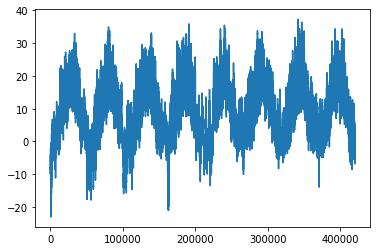

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

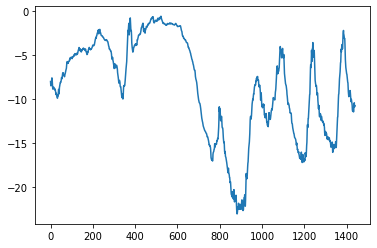

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 17s 34ms/step - loss: 1.6150 - val_loss: 1.4915
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.5935 - val_loss: 0.3473
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3165 - val_loss: 0.2630
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2787 - val_loss: 0.2048
Epoch 5/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2590 - val_loss: 0.2018
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2492 - val_loss: 0.2705
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2408 - val_loss: 0.1863
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2355 - val_loss: 0.2351
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2307 - val_loss: 0.3448
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.227

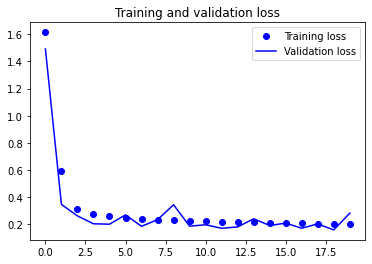

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() # why is my training and val loss so similar?

In [13]:
model2 = Sequential()
model2.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model2.add(layers.Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')
hist = model2.fit_generator(train_gen, steps_per_epoch=100, epochs=10,
                            validation_data=val_gen, validation_steps=val_steps)

Epoch 1/10
100/100 [==============================] - 51s 508ms/step - loss: 0.3533 - val_loss: 0.2150
Epoch 2/10
100/100 [==============================] - 49s 485ms/step - loss: 0.3025 - val_loss: 0.2143
Epoch 3/10
100/100 [==============================] - 48s 481ms/step - loss: 0.2960 - val_loss: 0.1875
Epoch 4/10
100/100 [==============================] - 48s 483ms/step - loss: 0.2910 - val_loss: 0.1968
Epoch 5/10
100/100 [==============================] - 48s 477ms/step - loss: 0.2904 - val_loss: 0.2077
Epoch 6/10
100/100 [==============================] - 48s 476ms/step - loss: 0.2865 - val_loss: 0.1701
Epoch 7/10
100/100 [==============================] - 48s 479ms/step - loss: 0.2864 - val_loss: 0.1680
Epoch 8/10
100/100 [==============================] - 48s 484ms/step - loss: 0.2846 - val_loss: 0.1586
Epoch 9/10
100/100 [==============================] - 48s 482ms/step - loss: 0.2848 - val_loss: 0.1770
Epoch 10/10
100/100 [==============================] - 48s 477ms/step - l

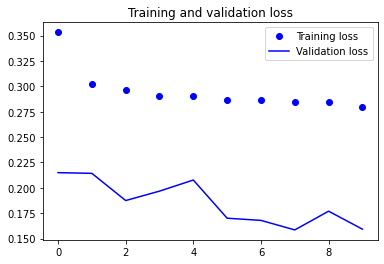

In [14]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() # my values are much lower than the book (loss of 0.16 vs 0.27)
# because of my steps?

In [ ]:
model3 = Sequential()
model3.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, 
                     input_shape=(None, float_data.shape[-1])))
model3.add(layers.Dense(1))
model3.compile(optimizer=RMSprop(), loss='mae')
hist3 = model3.fit_generator(train_gen, steps_per_epoch=50, epochs=5,
                             validation_data=val_gen,
                             validation_steps=val_steps)
# nan loss ...

In [ ]:
model4 = Sequential()
model4.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model4.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model4.add(layers.Dense(1))

model4.compile(optimizer=RMSprop(), loss='mae')
history4 = model4.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
# still nan loss...

In [ ]:
model5 = Sequential()
model5.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])
))
model5.add(layers.Dense(1))
model5.compile(optimizer=RMSprop(), loss='mae')
hist5 = model5.fit_generator(train_gen, steps_per_epoch=100, epochs=10,
                            validation_data=val_gen, validation_steps=val_steps)
# takes really long... 76s
# overfit quickly
# 0.29 loss